In [8]:
#Necessary Imports for EDA
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

def monthly_EDA(path):
    monthly = dd.read_csv(path, sep='|',
                          header=None, dtype={23: 'object',
                                              24: 'object',
                                              28: 'object',
                                              29: 'object',
                                              3: 'object',
                                              7: 'object'})
    
    monthly.columns = ["loan_sequence_number", "monthly_reporting_period", "current_actual_upb",
                       "current_loan_delinquency_status", "loan_age",
                       "remaining_months_to_maturity",
                       "repurchase_flag", "modification_flag", "zero_balance_code",
                       "zero_balance_effective_date", "current_interest_rate",
                       "current_deferred_upb",
                       "due_date_last_installment",
                       "insurance_recoveries", "net_sales_proceeds", "non_insurance_recoveries",
                       "expenses",
                       "legal_costs", "maintenance_costs", "taxes_and_insurance", "misc_expenses",
                       "actual_loss", "modification_cost", "step_modification_flag",
                       "deferred_payment_modification", "loan_to_value", "zero_balance_removal_upb",
                       "delinquent_accrued_interest" ,"del_disaster" ,"borrower_assistance" ,"month_mod_cost"
                       ,"interest_bearing"]
    print("First 5 rows of the dataset")
    display(monthly.head())
    print(" ")
    print("Number of Rows: " + str(monthly.shape[0].compute()))
    print(" ")
    summary = monthly.describe()
    print("Summary Statistics:")
    display(summary.compute())

    print("Since the dataset is so large, it's better to take a sample. This will make the EDA process faster.")
    print(" ")

    month_sub = monthly.sample(frac=0.1, random_state=42).compute()  # Adjust frac according to your needs

    print("Distribution of Numerical Columns")
    dates = ['monthly_reporting_period','repurchase_flag',"zero_balance_effective_date",'due_date_last_installment']
    for column in month_sub.select_dtypes(include=['float64', 'int64']).columns:
        plt.figure(figsize=(10, 6))
        if column not in dates:
            sns.histplot(month_sub[column], kde=True)
        else: #for columns with date values 
            no_nans = month_sub[column].dropna()
            sliced_data = no_nans.astype(str).str.slice(0,4) #extra data cleaning
            sns.histplot(data = no_nans.astype(int), bins = sorted((sliced_data.unique()+ "00").astype(int)),kde =True)
    plt.title(f'Distribution of {column}')
    plt.show()
    print(" ")
    print("Proportion of Nulls in the dataframe")
    print(" ")
    nans = month_sub.isna().sum( )/ month_sub.shape[0]
    display(nans)
    print(" ")

    # Create a list with columns with nan values
    nan_cols = []
    for i in range(len(nans)):
        if nans[i] >0:
            nan_cols.append(nans.index[i])

    # Divide Columns into categorical and numerical lists
    cat_nulls = ['repurchase_flag',
                 'modification_flag',
                 'zero_balance_code',
                 'zero_balance_effective_date',
                 'due_date_last_installment',
                 'step_modification_flag',
                 'deferred_payment_modification',
                 'loan_to_value',
                 'del_disaster',
                 'borrower_assistance']
    num_nulls = ['insurance_recoveries',
                 'net_sales_proceeds',
                 'non_insurance_recoveries',
                 'legal_costs',
                 'maintenance_costs',
                 'taxes_and_insurance',
                 'misc_expenses',
                 'actual_loss',
                 'modification_cost',
                 'zero_balance_removal_upb',
                 'delinquent_accrued_interest',
                 'month_mod_cost']

    print("Conduct a Chi Square test to check if null values in one column are dependent on another column. Then display which columns are dependent on each other.")
    missingness_df = pd.DataFrame()
    col1 = []
    col2 = []
    dependent = []
    from scipy.stats import chi2_contingency
    for i in cat_nulls:
        for j in nan_cols:
            observed = pd.crosstab(month_sub[i].isnull(), month_sub[j].isnull())
            chi2, p, dof, expected = chi2_contingency(observed)
            if p < 0.05:
                dependent.append(True)
            else:
                dependent.append(False)
            col1.append(i)
            col2.append(j)

    missingness_df['column_1'] = col1
    missingness_df['column_2'] = col2
    missingness_df['dependent'] = dependent

    display(missingness_df.head(10))
    print(" ")

    print("Check correlations for numerical columns")
    sns.heatmap(month_sub[num_nulls].corr(), annot=True, cmap= 'magma', fmt='.2f')

First 5 rows of the dataset


,loan_sequence_number,monthly_reporting_period,current_actual_upb,current_loan_delinquency_status,loan_age,remaining_months_to_maturity,repurchase_flag,modification_flag,zero_balance_code,zero_balance_effective_date,...,modification_cost,step_modification_flag,deferred_payment_modification,loan_to_value,zero_balance_removal_upb,delinquent_accrued_interest,del_disaster,borrower_assistance,month_mod_cost,interest_bearing
0,F09Q10000001,200903,274000.0,0,0,360,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274000.0
1,F09Q10000001,200904,274000.0,0,1,359,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274000.0
2,F09Q10000001,200905,274000.0,0,2,358,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274000.0
3,F09Q10000001,200906,273000.0,0,3,357,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273000.0
4,F09Q10000001,200907,273000.0,0,4,356,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273000.0


 
Number of Rows: 34150513
 
Summary Statistics:


,monthly_reporting_period,current_actual_upb,loan_age,remaining_months_to_maturity,repurchase_flag,zero_balance_code,zero_balance_effective_date,current_interest_rate,current_deferred_upb,due_date_last_installment,...,maintenance_costs,taxes_and_insurance,misc_expenses,actual_loss,modification_cost,loan_to_value,zero_balance_removal_upb,delinquent_accrued_interest,month_mod_cost,interest_bearing
count,3.415051e+07,3.415051e+07,3.415051e+07,3.415051e+07,1141.000000,593110.000000,593109.000000,3.415051e+07,3.415051e+07,47615.000000,...,5379.000000,5379.000000,5379.000000,5410.000000,4011.000000,4.042721e+06,5.931100e+05,6543.000000,251304.000000,3.415051e+07
mean,2.012337e+05,1.792234e+05,4.208316e+01,2.865958e+02,201188.929010,1.209103,201280.206557,4.907218e+00,3.915063e+01,201888.561231,...,-5732.103612,-7059.068210,-938.392389,-67886.694651,8222.330132,1.453618e+02,1.976966e+05,13302.523917,131.298271,1.791842e+05
std,3.225698e+02,1.078897e+05,3.819135e+01,7.821757e+01,181.832281,3.598379,285.346969,3.749404e-01,1.526580e+03,355.886338,...,9201.310395,12867.582522,2349.803295,64966.979413,15748.831269,3.044590e+02,1.132996e+05,18436.119250,258.691078,1.078661e+05
min,2.009010e+05,0.000000e+00,0.000000e+00,-8.000000e+00,200904.000000,1.000000,200901.000000,2.000000e+00,0.000000e+00,200901.000000,...,-103648.880000,-269438.080000,-77988.440000,-735370.080000,-25035.310000,1.000000e+00,1.000000e-02,-1446.430000,-737.800000,0.000000e+00
25%,2.010090e+05,1.216138e+05,1.700000e+01,2.940000e+02,201107.000000,1.000000,201111.000000,4.750000e+00,0.000000e+00,201911.000000,...,-3906.970000,-5484.797500,-731.462500,-70089.780000,602.925000,3.000000e+01,1.447927e+05,4046.882500,2.890000,1.216002e+05
50%,2.012040e+05,1.890568e+05,3.600000e+01,3.330000e+02,201206.250000,1.000000,201211.000000,4.875000e+00,0.000000e+00,202010.000000,...,-365.390000,-2420.100000,-290.000000,-36951.395000,4743.685000,4.400000e+01,2.163284e+05,10591.080000,114.625000,1.890541e+05
75%,2.015040e+05,3.120000e+05,7.100000e+01,3.500000e+02,201406.000000,1.000000,201504.000000,5.375000e+00,0.000000e+00,202109.000000,...,0.000000,0.000000,-145.000000,-9865.530000,19651.800000,6.700000e+01,3.391482e+05,21715.430000,294.925000,3.119829e+05
max,2.023030e+05,1.078000e+06,1.700000e+02,5.490000e+02,202007.000000,96.000000,202303.000000,7.875000e+00,1.970322e+05,203905.000000,...,500.000000,182580.940000,19626.290000,86720.730000,373262.340000,9.990000e+02,1.015495e+06,287715.400000,50779.680000,1.078000e+06


Since the dataset is so large, it's better to take a sample. This will make the EDA process faster.
 
Distribution of Numerical Columns


<ipython-input-6-f85b62a8aeb8>:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


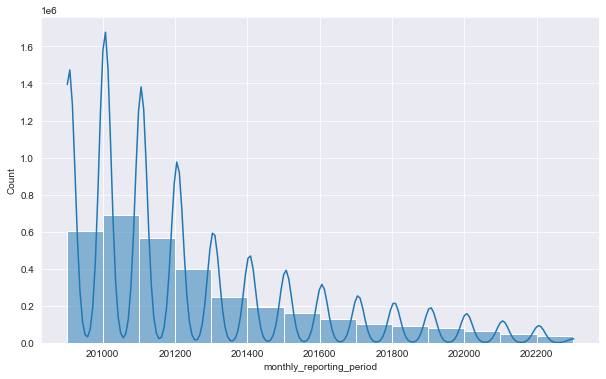

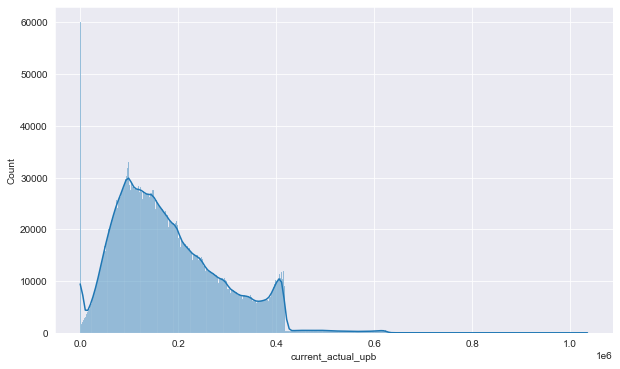

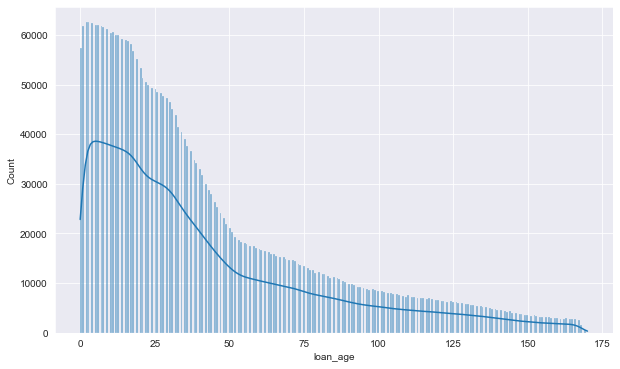

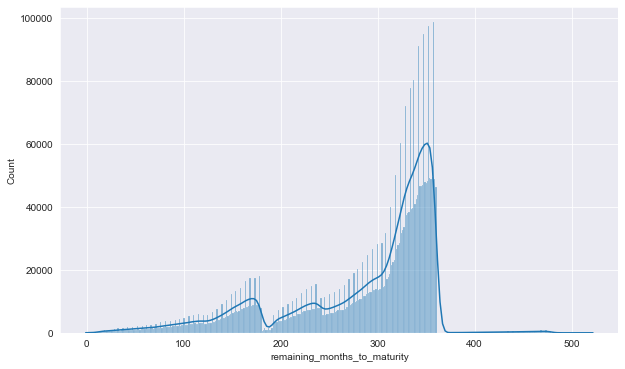

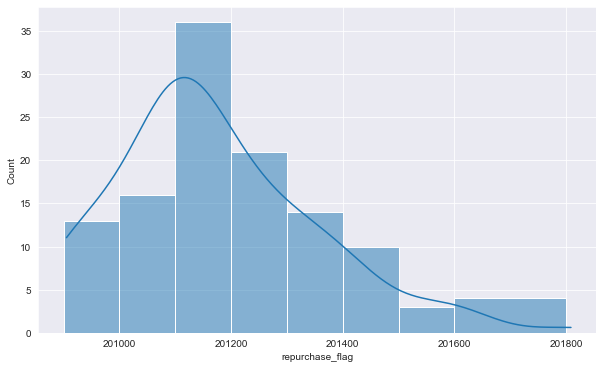

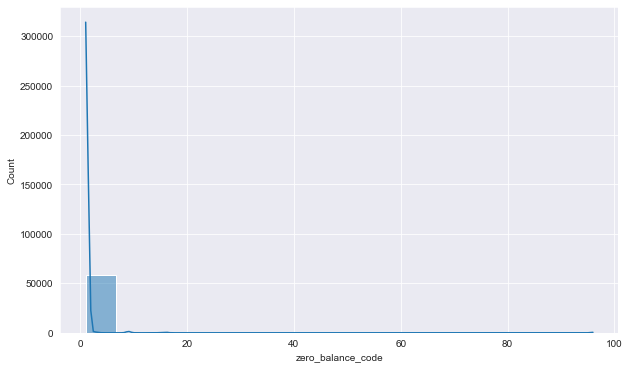

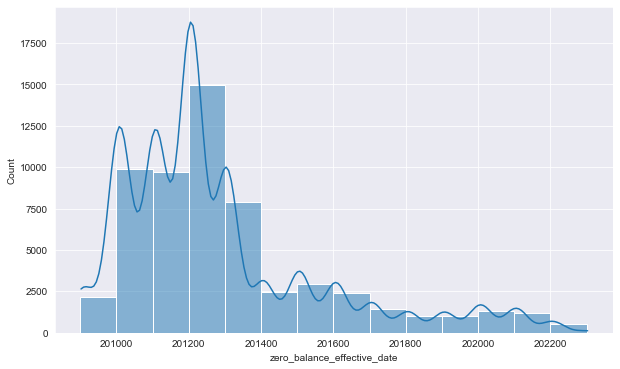

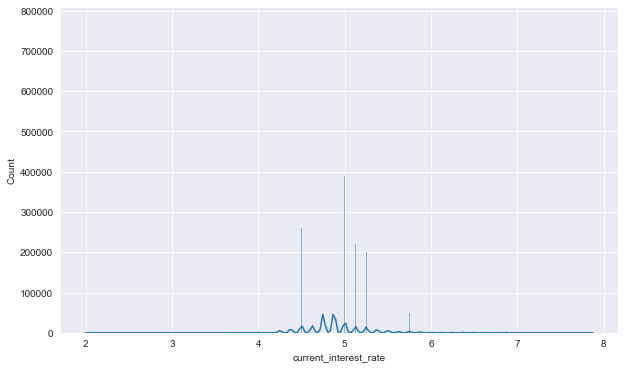

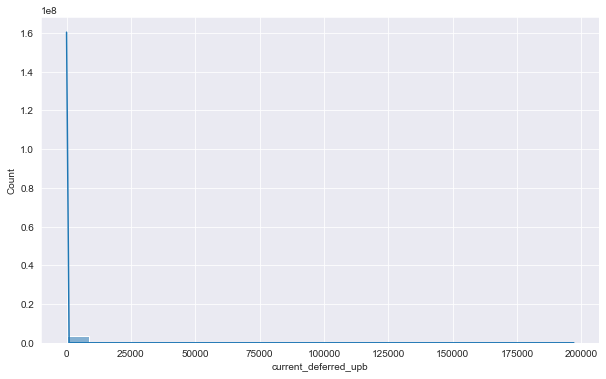

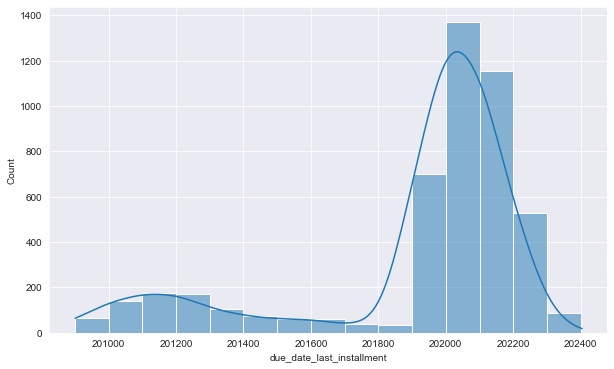

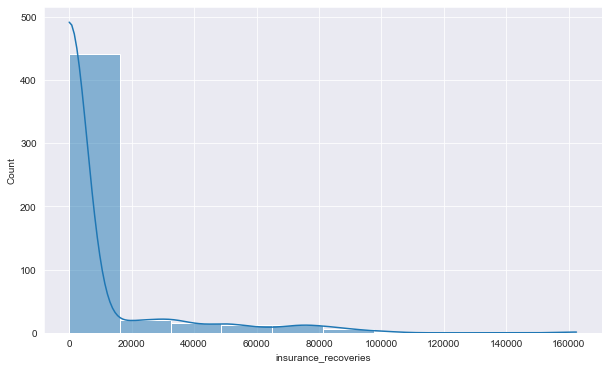

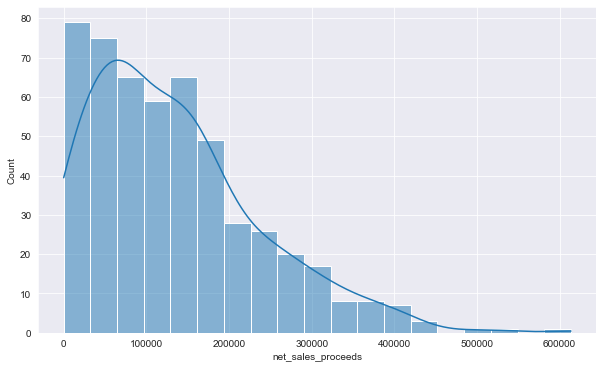

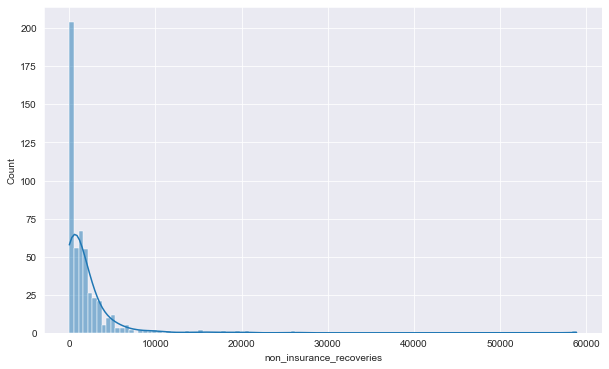

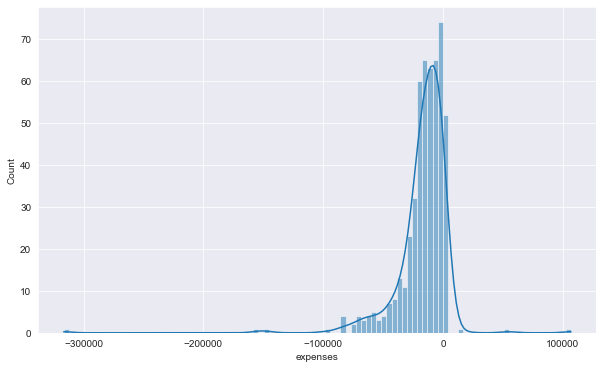

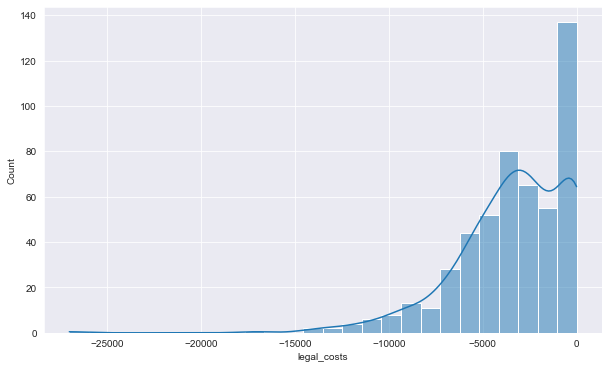

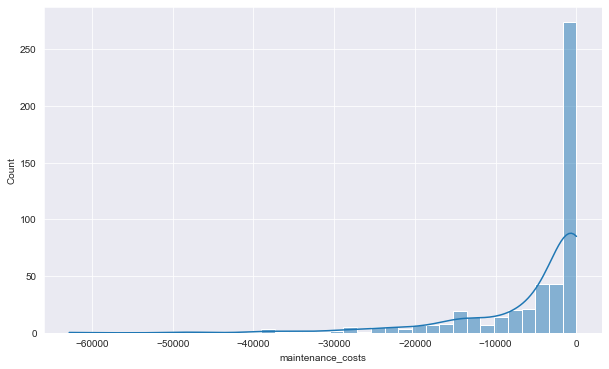

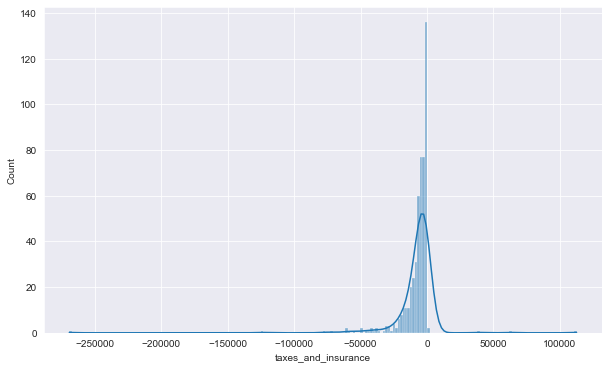

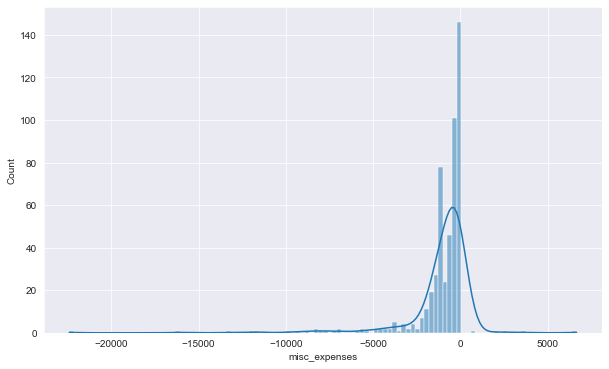

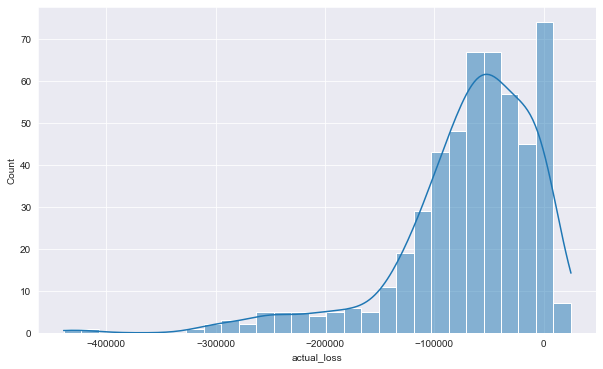

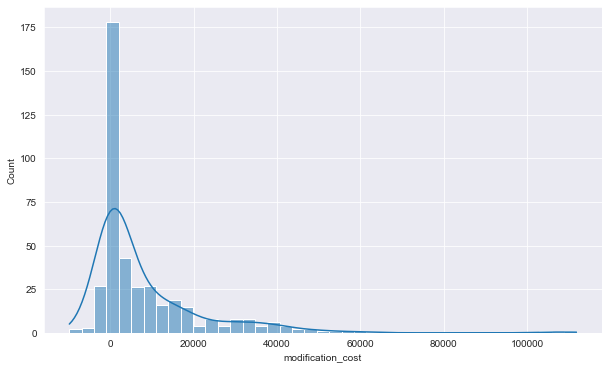

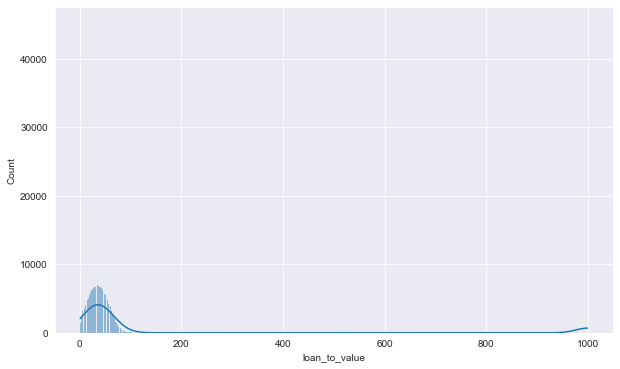

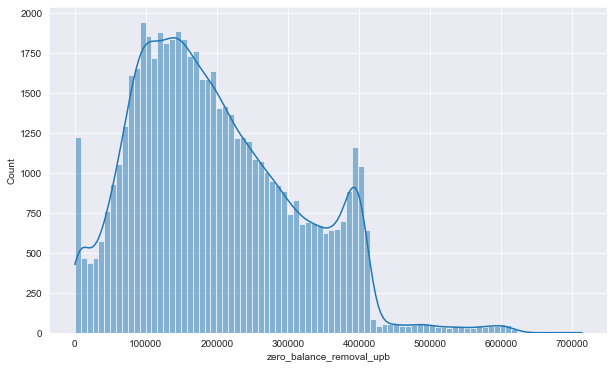

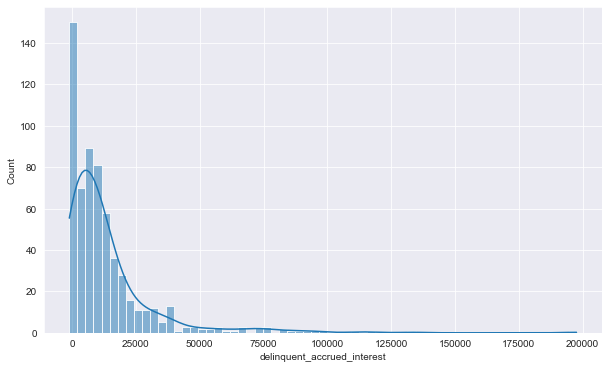

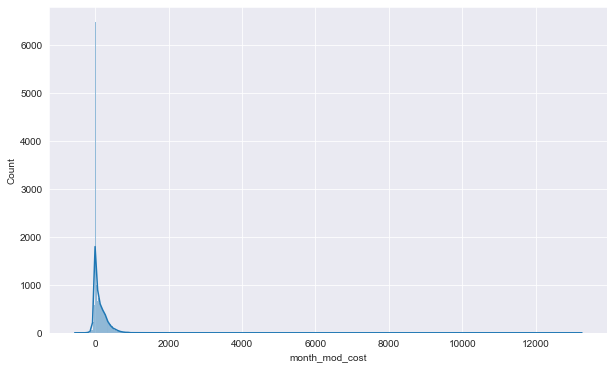

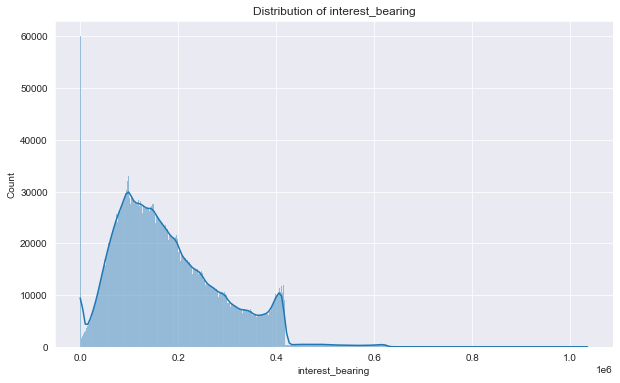

 
Proportion of Nulls in the dataframe
 


loan_sequence_number               0.000000
monthly_reporting_period           0.000000
current_actual_upb                 0.000000
current_loan_delinquency_status    0.000000
loan_age                           0.000000
remaining_months_to_maturity       0.000000
repurchase_flag                    0.999965
modification_flag                  0.993444
zero_balance_code                  0.982708
zero_balance_effective_date        0.982708
current_interest_rate              0.000000
current_deferred_upb               0.000000
due_date_last_installment          0.998605
insurance_recoveries               0.999851
net_sales_proceeds                 0.999850
non_insurance_recoveries           0.999851
expenses                           0.999851
legal_costs                        0.999851
maintenance_costs                  0.999851
taxes_and_insurance                0.999851
misc_expenses                      0.999851
actual_loss                        0.999850
modification_cost               

 
Conduct a Chi Square test to check if null values in one column are dependent on another column. Then display which columns are dependent on each other.


,column_1,column_2,dependent
0,repurchase_flag,repurchase_flag,True
1,repurchase_flag,modification_flag,True
2,repurchase_flag,zero_balance_code,True
3,repurchase_flag,zero_balance_effective_date,True
4,repurchase_flag,due_date_last_installment,True
5,repurchase_flag,insurance_recoveries,True
6,repurchase_flag,net_sales_proceeds,True
7,repurchase_flag,non_insurance_recoveries,True
8,repurchase_flag,expenses,True
9,repurchase_flag,legal_costs,True


 
Check correlations for numerical columns


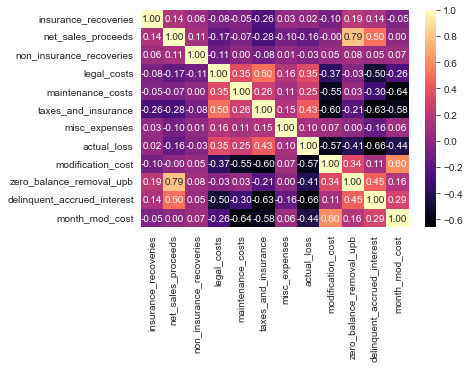

In [7]:
monthly_EDA('/Users/riyamhatre/Downloads/historical_data_2009Q1/historical_data_time_2009Q1.txt')

In [9]:
def origination_EDA(path):
    org = pd.read_csv('/Users/riyamhatre/Downloads/historical_data_2009Q1/historical_data_2009Q1.txt', sep='|', header = None,dtype={25: 'object',
       26: 'object',
       28: 'object'})
    
    org = org.drop(columns = {26, 27,28,29,30,31})
    org.columns = ["credit_score", "first_payment_date", "first_time_homebuyer", "maturity_date",
                                       "metropolitan_division", "mortgage_insurance_percent", "number_of_units",
                                       "occupancy_status", "orig_combined_loan_to_value", "dti_ratio",
                                       "original_unpaid_principal_balance", "original_ltv", "original_interest_rate",
                                       "channel", "prepayment_penalty_mortgage", "product_type", "property_state",
                                       "property_type", "postal_code", "loan_sequence_number", "loan_purpose",
                                       "original_loan_term",
                                       "number_of_borrowers", "seller_name", "servicer_name", "super_conforming_flag"]
    
    print("Number of Rows: " + str(org.shape[0]))
    print(" ")
    summary = org.describe()
    print("Summary Statistics:")
    display(summary)
    print(' ')
    
    print("Proportion of Nulls in the dataframe")
    nans = org.isna().sum()/ org.shape[0]
    display(nans)
    print(" ")
    print("Distribution of Numerical Columns")
    for column in org.select_dtypes(include=['float64', 'int64']).columns:
        plt.figure(figsize=(10, 6))
        if column == "credit_score":
            sns.histplot(data = org[org['credit_score'] != 9999]['credit_score'], kde=True)
            plt.title(f'Distribution of credit_score')
            plt.show()
        elif column == 'first_payment_date':
            no_nans = org[org['first_payment_date'] < 201150]['first_payment_date'].dropna()
            sns.histplot(data = no_nans, bins = [200900,201000,201100,201150], kde = True)
            plt.title(f'Distribution of {column}')
            plt.show()
        elif column == "maturity_date": 
            temp = org
            temp = temp.groupby('maturity_date').count()['credit_score'].to_frame().reset_index().sort_values(by = "credit_score")
            temp['year'] = temp['maturity_date'].astype(str).str.slice(0,4) + '00'
            temp.groupby('year').sum().sort_values(by = 'year')
            sns.barplot(data =temp.groupby('year').sum().sort_values(by = 'year').reset_index().rename(columns = {'Count':'credit_score'}) ,x = "year", y = 'credit_score')
            plt.xticks(rotation=45)
            plt.title(f'Distribution of {column}')
            plt.show()
        else:
            sns.histplot(org[column], kde=True)
            plt.title(f'Distribution of {column}')
            plt.show()

Number of Rows: 621538
 
Summary Statistics:


,credit_score,first_payment_date,maturity_date,metropolitan_division,mortgage_insurance_percent,number_of_units,orig_combined_loan_to_value,dti_ratio,original_unpaid_principal_balance,original_ltv,original_interest_rate,postal_code,original_loan_term,number_of_borrowers
count,621538.000000,621538.000000,621538.000000,495222.000000,621538.000000,621538.000000,621538.000000,621538.000000,6.215380e+05,621538.000000,621538.000000,621538.000000,621538.000000,621538.000000
mean,764.067569,200904.179883,203632.272556,30117.608115,1.500193,1.010262,66.244440,36.285331,2.200397e+05,64.751029,4.936954,52634.404011,327.511795,1.662037
std,87.631396,2.727331,559.856660,11448.659739,6.413336,0.133182,17.385102,69.679703,1.124279e+05,17.341477,0.363556,29424.261945,67.169654,1.440264
min,448.000000,200901.000000,201402.000000,10180.000000,0.000000,1.000000,6.000000,1.000000,8.000000e+03,6.000000,2.750000,600.000000,60.000000,1.000000
25%,742.000000,200903.000000,203902.000000,18140.000000,0.000000,1.000000,56.000000,22.000000,1.310000e+05,54.000000,4.750000,28200.000000,360.000000,1.000000
50%,773.000000,200904.000000,203903.000000,31540.000000,0.000000,1.000000,70.000000,31.000000,2.000000e+05,69.000000,4.875000,53100.000000,360.000000,2.000000
75%,793.000000,200905.000000,203904.000000,40140.000000,0.000000,1.000000,80.000000,40.000000,2.950000e+05,79.000000,5.125000,80100.000000,360.000000,2.000000
max,9999.000000,201509.000000,205501.000000,49740.000000,999.000000,4.000000,999.000000,999.000000,1.080000e+06,999.000000,7.875000,99900.000000,549.000000,99.000000


 
Proportion of Nulls in the dataframe


credit_score                         0.000000
first_payment_date                   0.000000
first_time_homebuyer                 0.000000
maturity_date                        0.000000
metropolitan_division                0.203231
mortgage_insurance_percent           0.000000
number_of_units                      0.000000
occupancy_status                     0.000000
orig_combined_loan_to_value          0.000000
dti_ratio                            0.000000
original_unpaid_principal_balance    0.000000
original_ltv                         0.000000
original_interest_rate               0.000000
channel                              0.000000
prepayment_penalty_mortgage          0.000000
product_type                         0.000000
property_state                       0.000000
property_type                        0.000000
postal_code                          0.000000
loan_sequence_number                 0.000000
loan_purpose                         0.000000
original_loan_term                

 
Distribution of Numerical Columns


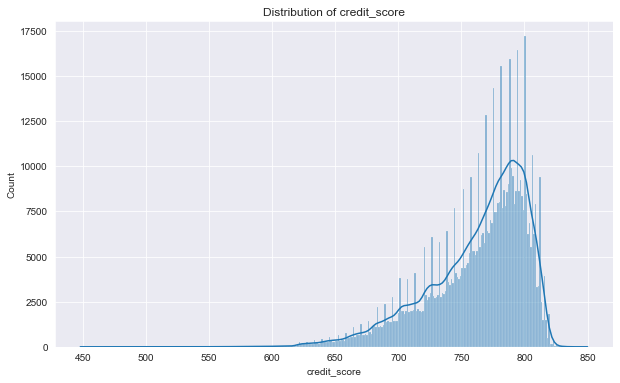

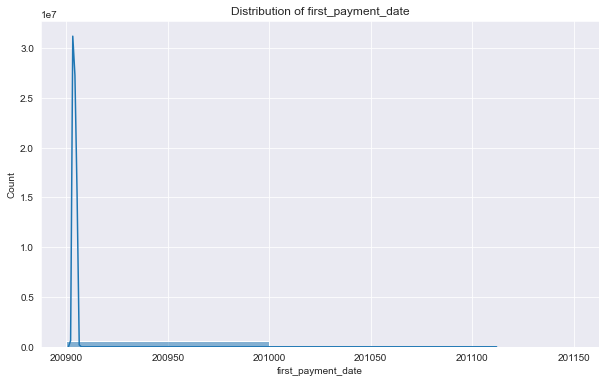

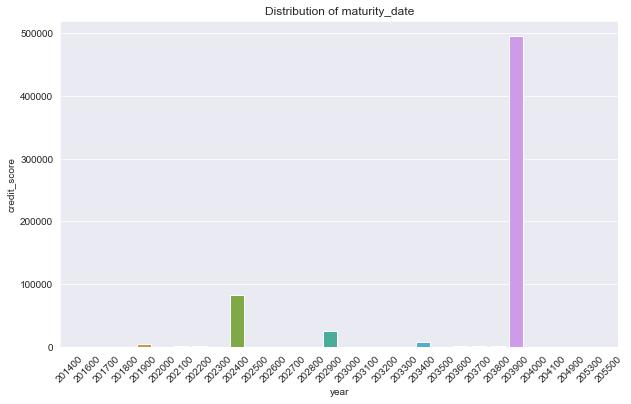

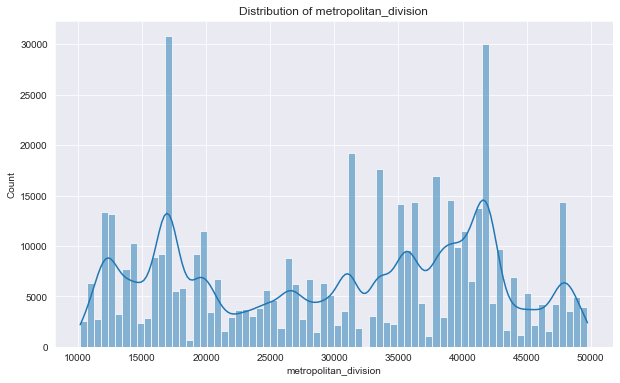

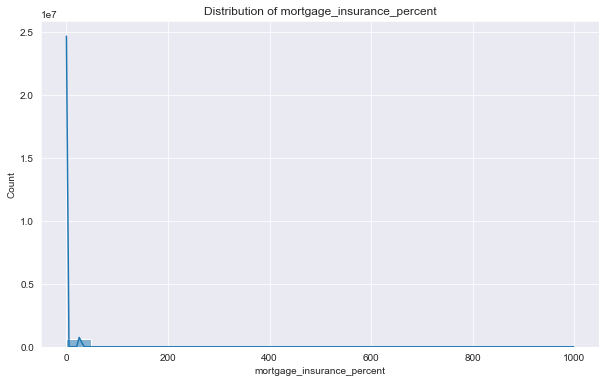

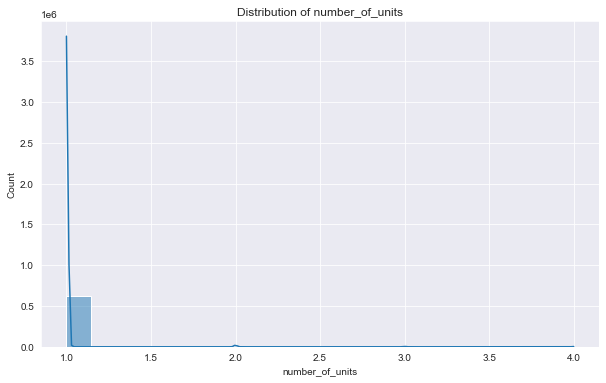

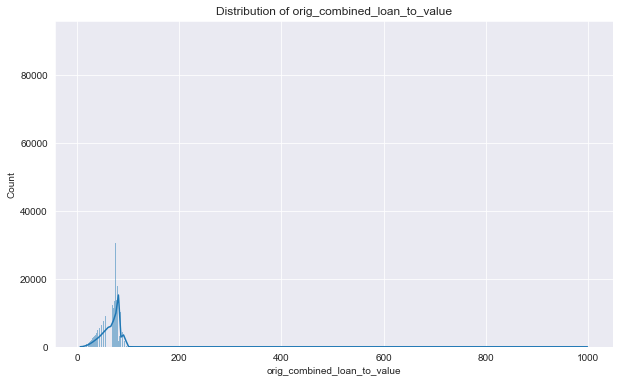

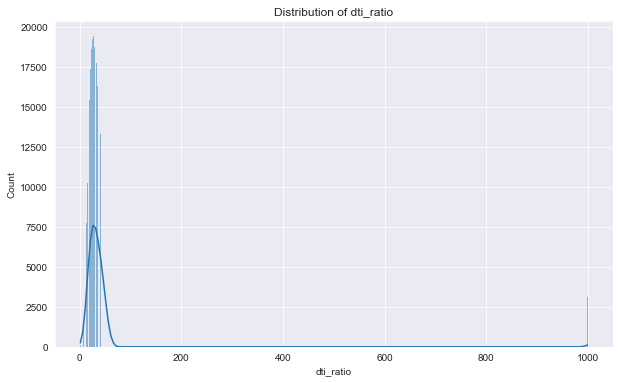

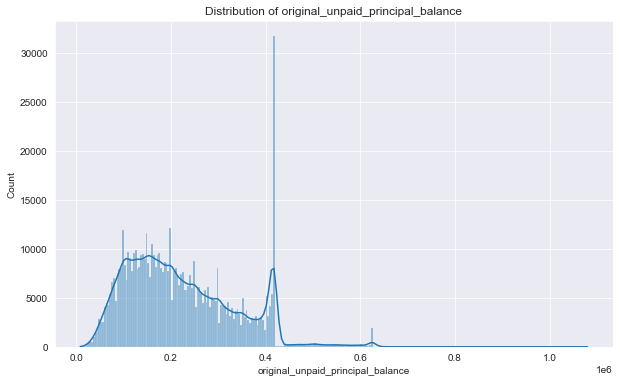

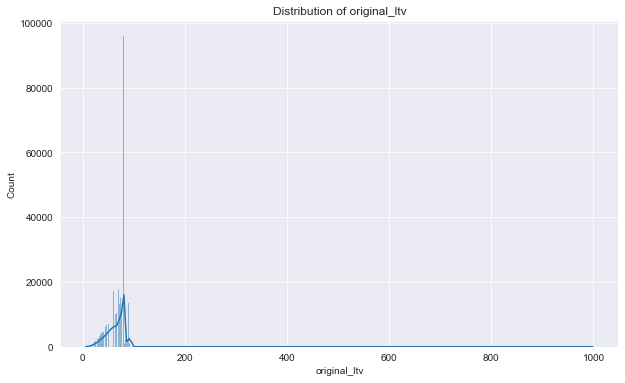

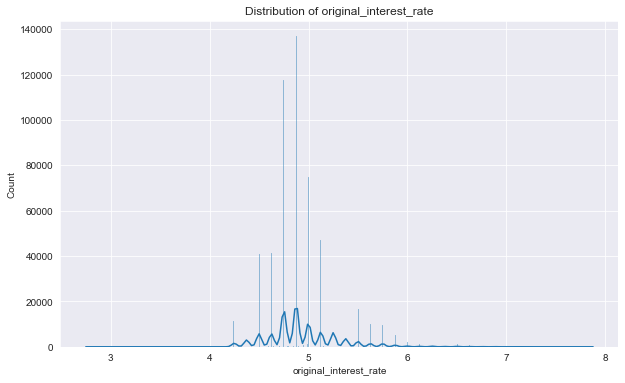

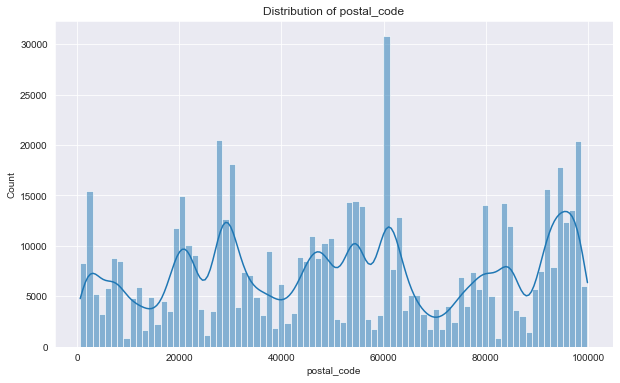

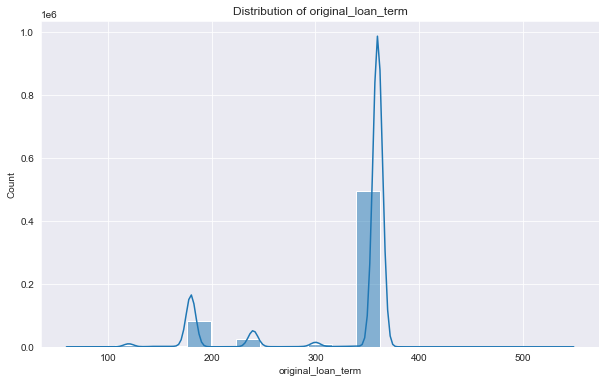

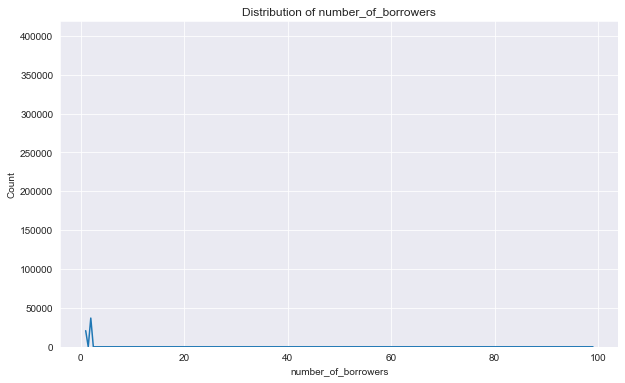

In [10]:
origination_EDA('/Users/riyamhatre/Downloads/historical_data_2009Q1/historical_data_2009Q1.txt')